## Weather Image Recognition

In [1]:
#Import libraries
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import shutil
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import zipfile

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


In [2]:
# !pip install kaggle
!mkdir -p /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"----------------","key":"----------------------"}')
    #Be able to access Kaggle files

!chmod 600 /root/.kaggle/kaggle.json

In [3]:
#Import Google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#download data from kaggle
!kaggle datasets download -d jehanbhathena/weather-dataset
!mkdir -p "/content/data"

!unzip -qo "weather-dataset" -d "/content/data"

100% 586M/587M [00:04<00:00, 132MB/s]
100% 587M/587M [00:04<00:00, 133MB/s]


In [5]:
#data directories
data = "/content/data/dataset"
!mkdir -p "/content/data/train" "/content/data/valid" "/content/data/test"

train, valid, test = "/content/data/train", "/content/data/valid", "/content/data/test"

In [6]:
#Define the split ratio
train_ratio = 0.7
test_ratio = 0.15

#Loop through subfolders and split the data
for subfolder in os.listdir(data):
    class_path = os.path.join(data, subfolder)

    files = os.listdir(class_path)
    random.shuffle(files)
    train_split = int(train_ratio * len(files))
    test_split = int(test_ratio * len(files))

    train_files = files[ : train_split]
    test_files = files[train_split : train_split + test_split]
    valid_files = files[train_split + test_split : ]

    #Create subdirectories for each class
    os.makedirs(os.path.join(train, subfolder), exist_ok=True)
    os.makedirs(os.path.join(test, subfolder), exist_ok=True)
    os.makedirs(os.path.join(valid, subfolder), exist_ok=True)

    #Move files to respective directories
    for file in train_files:
        try:
            shutil.move(os.path.join(class_path, file), os.path.join(train, subfolder))
        except Exception as e:
            print(f"Error moving {file} to valid: {e}")
    for file in test_files:
        try:
            shutil.move(os.path.join(class_path, file), os.path.join(test, subfolder))
        except Exception as e:
            print(f"Error moving {file} to valid: {e}")
    for file in valid_files:
        try:
            shutil.move(os.path.join(class_path, file), os.path.join(valid, subfolder))
        except Exception as e:
            print(f"Error moving {file} to valid: {e}")

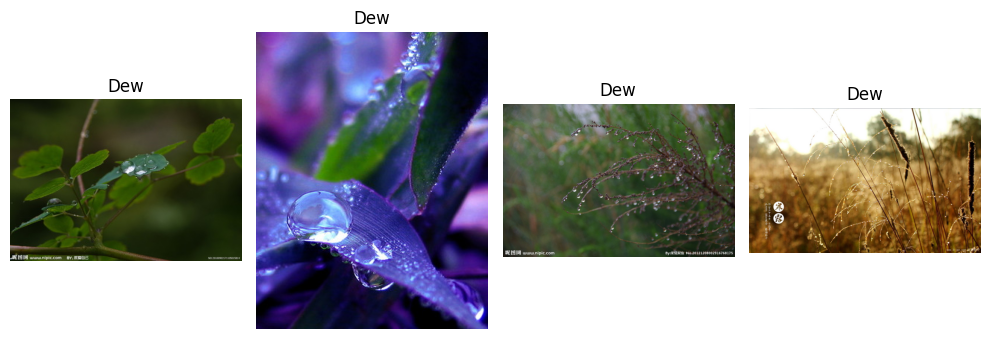

In [7]:
#Get the full path of the folder
folder_path = "/content/data/train/dew"

#Get the list of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

for i in range(4):
    col_idx = i
    #Read the image file
    image = plt.imread(os.path.join(folder_path, image_files[i]))
    axes[col_idx].imshow(image)
    axes[col_idx].set_title("Dew")
    axes[col_idx].axis("off")

fig.tight_layout()
#Show the images
plt.show()

In [8]:
#Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
#Create dataset class
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(root=data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create datasets
train_dataset = ImageDataset(train, transform=transform)
test_dataset = ImageDataset(test, transform=transform)
valid_dataset = ImageDataset(valid, transform=transform)

#Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [10]:
#Download the pretrained ResNet-101 model
resnet101 = models.resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 149MB/s]


In [11]:
#Modify the model
num_classes = 11
num_features = resnet101.fc.in_features
resnet101.fc = nn.Linear(num_features, num_classes)

#Set the model to evaluation mode
resnet101.eval()

#Example
input = torch.randn(1, 3, 224, 224)
output = resnet101(input)

print(output)

tensor([[-0.3588,  0.3298,  0.7414,  0.6690, -0.0567, -0.1749, -0.4459, -0.5077,
         -0.4050, -0.1175,  0.6234]], grad_fn=<AddmmBackward0>)


In [12]:
#Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet101.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4)

#Implement a scheduler
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=1, factor=0.1)

scaler = torch.cuda.amp.GradScaler()

In [13]:
def train(model, train_loader, valid_loader, num_epochs):
    #Set the model to training mode
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        r_correct = 0
        r_total = 0

        #Create a tqdm progress bar for the training data
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", dynamic_ncols=True)

        for i, (inputs, labels) in enumerate(train_bar, 0):
            #Zero the parameter gradients
            optimizer.zero_grad()

            #Forward pass
            outputs = model(inputs)

            #Compute the loss
            loss = criterion(outputs, labels)

            #Backpropagation and optimization
            loss.backward()
            optimizer.step()

            #Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            r_total += labels.size(0)
            r_correct += (predicted == labels).sum().item()

            #Update the progress bar description with the current loss and accuracy
            avg_loss = running_loss / (i + 1)
            accuracy = (r_correct / r_total) * 100
            train_bar.set_postfix({"Avg Loss": avg_loss, "Accuracy": accuracy})

            #Update the running loss for the epoch
            running_loss += loss.item()

        #Set the model to evaluation mode
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        #Create a tqdm progress bar for the validation data
        valid_bar = tqdm(valid_loader, desc="Validation", dynamic_ncols=True)

        with torch.no_grad():
            for inputs, labels in valid_bar:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                #Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                #Update the progress
                avg_val_loss = val_loss / (len(valid_bar) + 1)
                accuracy = (correct / total) * 100
                valid_bar.set_postfix({"Avg Loss": avg_val_loss, "Accuracy": accuracy})

        model.train()
        #Update the learning
        scheduler.step(avg_val_loss)

    print("Finished Training")

In [14]:
train(resnet101, train_loader, valid_loader, num_epochs=2)

Epoch 1/2:   0%|          | 0/300 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 2/2:   0%|          | 0/300 [00:00<?, ?it/s]

Validation:   0%|          | 0/66 [00:00<?, ?it/s]

Finished Training


In [15]:
def evaluate_model(model, test_loader):
    #Set the model to evaluation mode
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    print("Test Accuracy: %.2f%%" % accuracy)

In [16]:
evaluate_model(resnet101, test_loader)

Test Accuracy: 88.07%
